In [1]:
# Tang Kit Lim (WQD190032)

import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import distance
from pathlib import Path

In [2]:
# load data from csv

data_directory = '../data/processed/'
Path(data_directory).mkdir(parents=True, exist_ok=True)

preprocessed_township_csv = data_directory + 'edgeprop_townships_preprocessed.csv'
preprocessed_transaction_csv = data_directory + 'edgeprop_transactions_preprocessed.csv'
preprocessed_poi_csv = data_directory + 'iproperty_pois_preprocessed.csv'

transaction_csv = data_directory + 'edgeprop_transactions_processed.csv'

townships = pd.read_csv(preprocessed_township_csv, na_values=['None'], index_col=0)
transactions = pd.read_csv(preprocessed_transaction_csv, na_values=['None'], index_col=0)
pois = pd.read_csv(preprocessed_poi_csv, na_values=['None'], index_col=0)


## Merge Township dataset into Transaction dataset


In [3]:
# Merge using inner join, transactions without township information will be ignored

transactions = transactions.merge(townships, left_on='project_id', right_on='project_id', suffixes=('', '_township'))

## Data Cleaning


In [4]:
# create a backup in case need to redo processing
transactions_bk = transactions.copy()

In [5]:
transactions.shape

(204283, 31)

In [6]:
# check similar features
# transactions[(transactions['unit_price_psf'] != transactions['psf'])][['unit_price_psf', 'psf']].describe()
# 'psf' was recalculated during data preparation, keep 'psf' only, 'unit_price_psf' will be dropped


In [7]:
# check similar features
transactions[(transactions['transacted_price'] != transactions['price'])][['transacted_price', 'price']].describe()
# 'transacted_price' and 'price' are identical, keep 'price' only, 'transacted_price' will be dropped

,transacted_price,price
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [8]:
# check similar features
transactions[(transactions['state'] != transactions['state_township'])][[
    'state', 'state_township', 'project_id', 'latitude', 'longitude'
]]
# 'state' and 'state_township' are almost identical, with few exceptions. 
# 'state_township' is more accurate based on the gps location
# 'state' will be dropped, keep 'state_township' and will be renamed to 'state'

,state,state_township,project_id,latitude,longitude
11809,Kuala Lumpur,Selangor,12192,3.081360,101.762001
11997,Kuala Lumpur,Penang,12374,5.356920,100.429001
19307,Kuala Lumpur,Perak,12752,4.598970,101.056000
62289,Selangor,Johor,13183,1.571710,103.611000
76475,Johor,Penang,17337,5.269977,100.471551
76476,Johor,Penang,17337,5.269977,100.471551
76477,Johor,Penang,17337,5.269977,100.471551
76478,Johor,Penang,17337,5.269977,100.471551
76479,Johor,Penang,17337,5.269977,100.471551
76480,Johor,Penang,17337,5.269977,100.471551


## Handling Incorrect Data

In [9]:
# remove all transactions with gps coordination out of Malaysia
transactions = transactions[~(
    (transactions['latitude'] < 0.85) |
    (transactions['latitude'] > 7.4) |
    (transactions['longitude'] < 99.5) | 
    (transactions['longitude'] > 119.3) | 
    (pd.isna(transactions['latitude'])) |
    (pd.isna(transactions['longitude'])) 
)]


In [10]:
# extract year from epoch and store as new column
import time
transactions['year'] = transactions['date'].apply(
    lambda x: str(pd.Timestamp(x, unit='s')).split("-")[0]
)

In [11]:
# area (location of the transaction) & area_sqft (actualy area of the transaction in sqft) 
# could be confusing. Going to rename area as city.
transactions['area'].value_counts()

Johor Bahru      9100
Shah Alam        7988
Klang            6174
Puchong          5061
Kajang           4963
                 ... 
Layang Layang       3
Paloh               2
East Ledang         2
Ipoh                1
Gemas               1
Name: area, Length: 273, dtype: int64

In [12]:
# drop rows without values for 'psf'
# drop feature 'floor', too little observation 
# drop columns which are not useful for the current model: project_id, date, psf, latitude, longitude, median_price
# drop redundant features 'transacted_price', 'unit_price_psf', 'state'
# rename 'state_township' as 'state'
# 'median_psf', 'median_price', 'psf' will cause overfitting, 
# but it's usefull to detect outliers, keep for now, drop later.

transactions.dropna(subset = ['psf'], how = 'any', inplace = True)
transactions.drop(columns=[
    'floor', 'transacted_price', 'unit_price_psf', 'state', 'date', 'latitude', 'longitude'
], inplace = True)
transactions.rename(columns={'state_township': 'state', 'project_name': 'township', 'area': 'city'}, inplace = True)

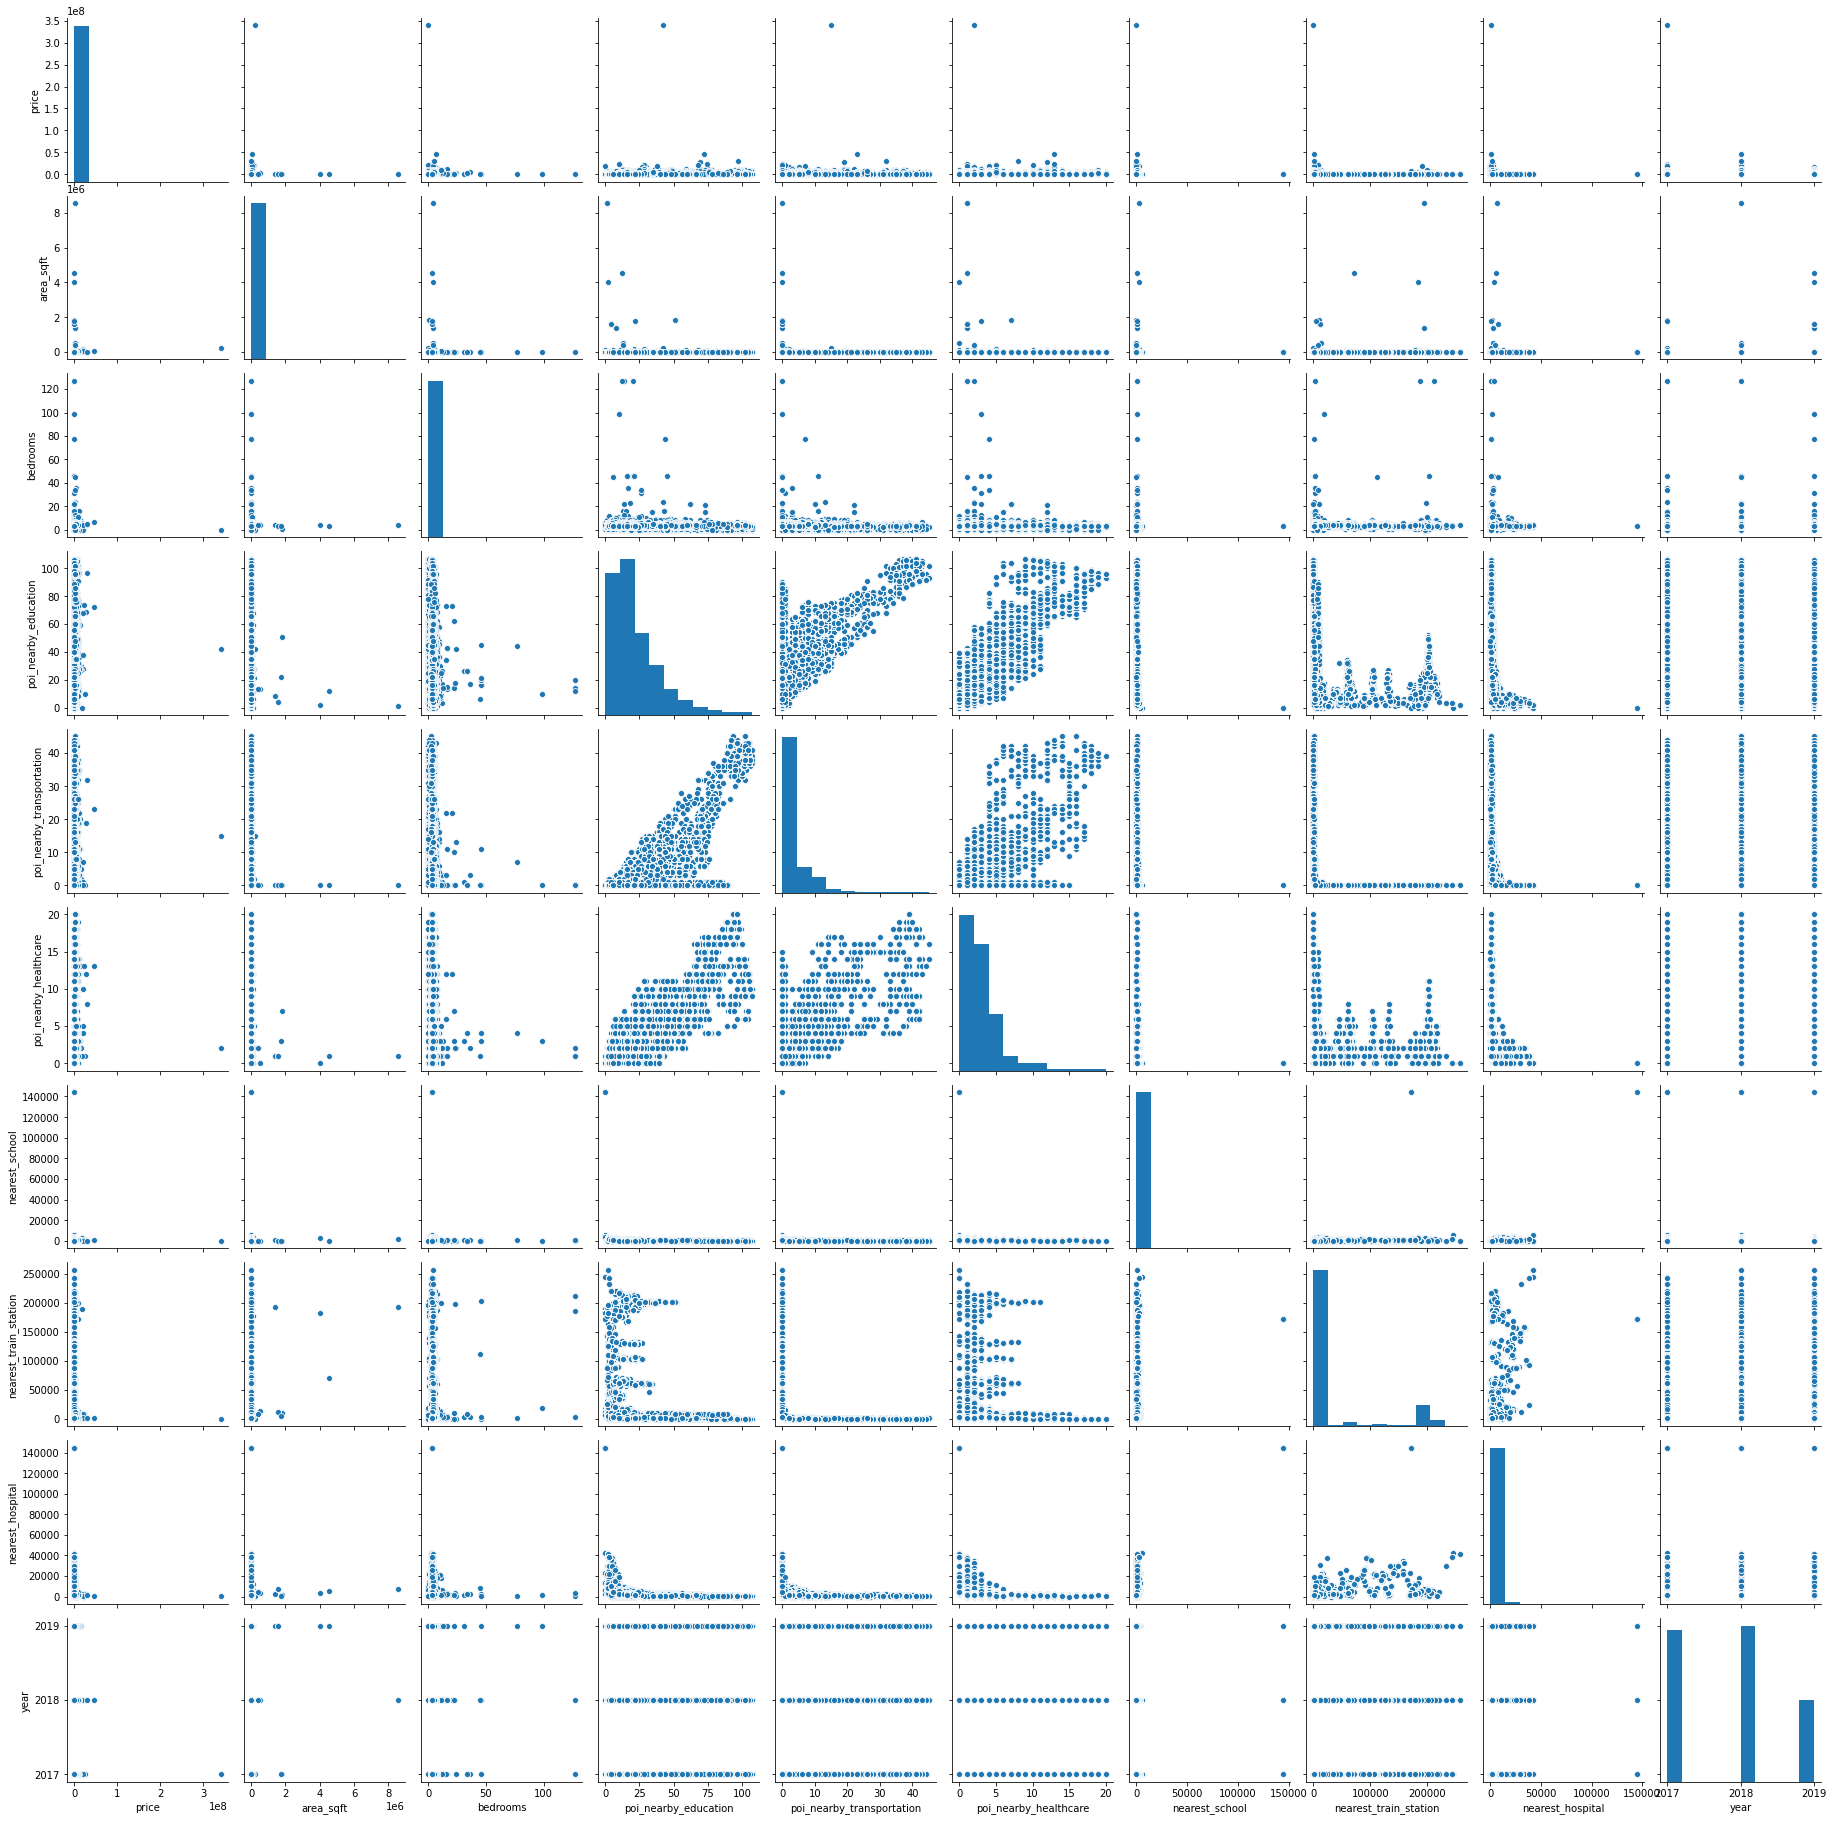

In [13]:
import matplotlib
import seaborn as sns
# sns.pairplot(transactions[['price', 'area_sqft', 'bedrooms', 'total_poi_nearby', 'nearest_poi']])
sns.pairplot(transactions[[
    'price', 'area_sqft', 'bedrooms', 'poi_nearby_education','poi_nearby_transportation','poi_nearby_healthcare', 
    'nearest_school', 'nearest_train_station', 'nearest_hospital', 'year'
]])

# Remove outliers

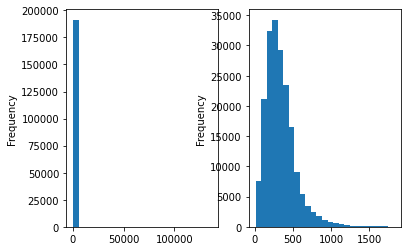

In [14]:

fig, axes = plt.subplots(1, 2)

transactions['psf'].plot.hist('Before', bins=25, ax=axes[0])

# transactions['psf'] = transactions['price']/transactions['area_sqft']
min_psf, max_psf = transactions['psf'].quantile([0.001, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['psf'] > min_psf) &
    (transactions['psf'] < max_psf)
]
transactions['psf'].plot.hist('After', bins=25, ax=axes[1])



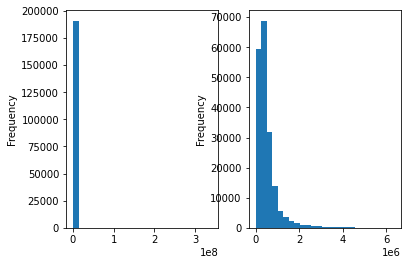

In [15]:
fig, axes = plt.subplots(1, 2)

transactions['price'].plot.hist('Before', bins=25, ax=axes[0])

min_price, max_price = transactions['price'].quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['price'] > min_price) &
    (transactions['price'] < max_price)
]

transactions['price'].plot.hist('After', bins=25, ax=axes[1])



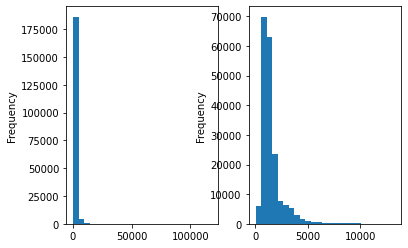

In [16]:
fig, axes = plt.subplots(1, 2)

transactions['area_sqft'].plot.hist('Before', bins=25, ax=axes[0])

min_area, max_area = transactions['area_sqft'].quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['area_sqft'] > min_area) &
    (transactions['area_sqft'] < max_area)
]

transactions['area_sqft'].plot.hist('After', bins=25, ax=axes[1])

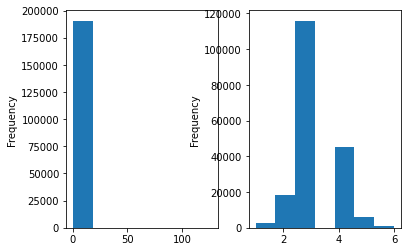

In [17]:
fig, axes = plt.subplots(1, 2)

transactions['bedrooms'].plot.hist('Before', bins=7, ax=axes[0])

min_bedroom, max_bedroom = transactions['bedrooms'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['bedrooms'] > min_bedroom) &
    (transactions['bedrooms'] < max_bedroom)
]

transactions['bedrooms'].plot.hist('After', bins=7, ax=axes[1])

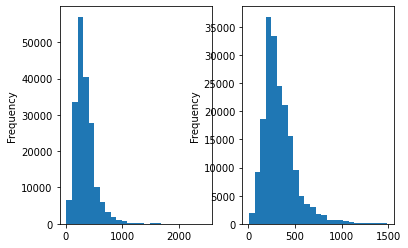

In [18]:
fig, axes = plt.subplots(1, 2)

transactions['median_psf'].plot.hist('Before', bins=25, ax=axes[0])

min_median_psf, max_median_psf = transactions['median_psf'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['median_psf'] > min_median_psf) &
    (transactions['median_psf'] < max_median_psf)
]

transactions['median_psf'].plot.hist('After', bins=25, ax=axes[1])

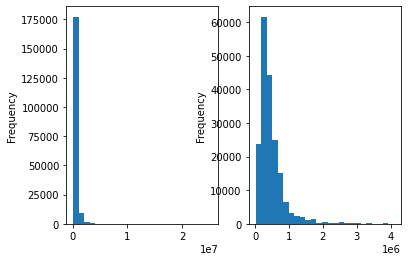

In [19]:
fig, axes = plt.subplots(1, 2)

transactions['median_price'].plot.hist('Before', bins=25, ax=axes[0])

min_median_price, max_median_price = transactions['median_price'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['median_price'] > min_median_price) &
    (transactions['median_price'] < max_median_price)
]

transactions['median_price'].plot.hist('After', bins=25, ax=axes[1])

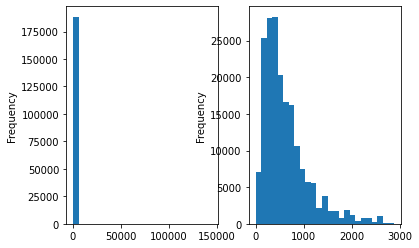

In [20]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_poi'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_poi'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_poi'] > min_nearest_poi) &
    (transactions['nearest_poi'] < max_nearest_poi)
]

transactions['nearest_poi'].plot.hist('After', bins=25, ax=axes[1])

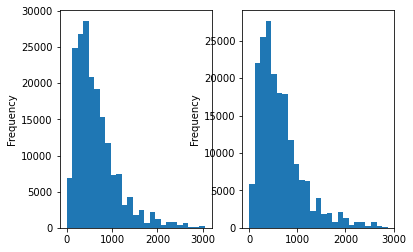

In [21]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_school'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_school'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_school'] > min_nearest_poi) &
    (transactions['nearest_school'] < max_nearest_poi)
]

transactions['nearest_school'].plot.hist('After', bins=25, ax=axes[1])

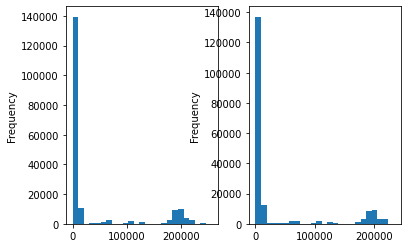

In [22]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_train_station'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_train_station'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_train_station'] > min_nearest_poi) &
    (transactions['nearest_train_station'] < max_nearest_poi)
]

transactions['nearest_train_station'].plot.hist('After', bins=25, ax=axes[1])

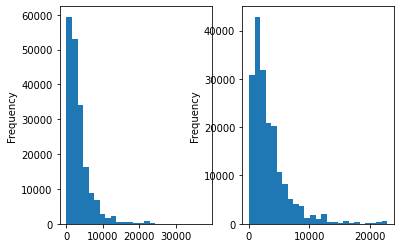

In [23]:
fig, axes = plt.subplots(1, 2)

transactions['nearest_hospital'].plot.hist('Before', bins=25, ax=axes[0])

min_nearest_poi, max_nearest_poi = transactions['nearest_hospital'].astype(int).quantile([0.00, 0.999])

# drop if they are outliers
transactions = transactions[
    (transactions['nearest_hospital'] > min_nearest_poi) &
    (transactions['nearest_hospital'] < max_nearest_poi)
]

transactions['nearest_hospital'].plot.hist('After', bins=25, ax=axes[1])

In [24]:
transactions['property_type'].value_counts()

Terrace House              81427
Condominium/Apartment      44728
Flat                       32059
Semi-Detached House         9873
Hotel/Service Apartment     7611
Detached House              4514
Cluster House               2727
Low-Cost House              2326
Town House                  2164
Name: property_type, dtype: int64

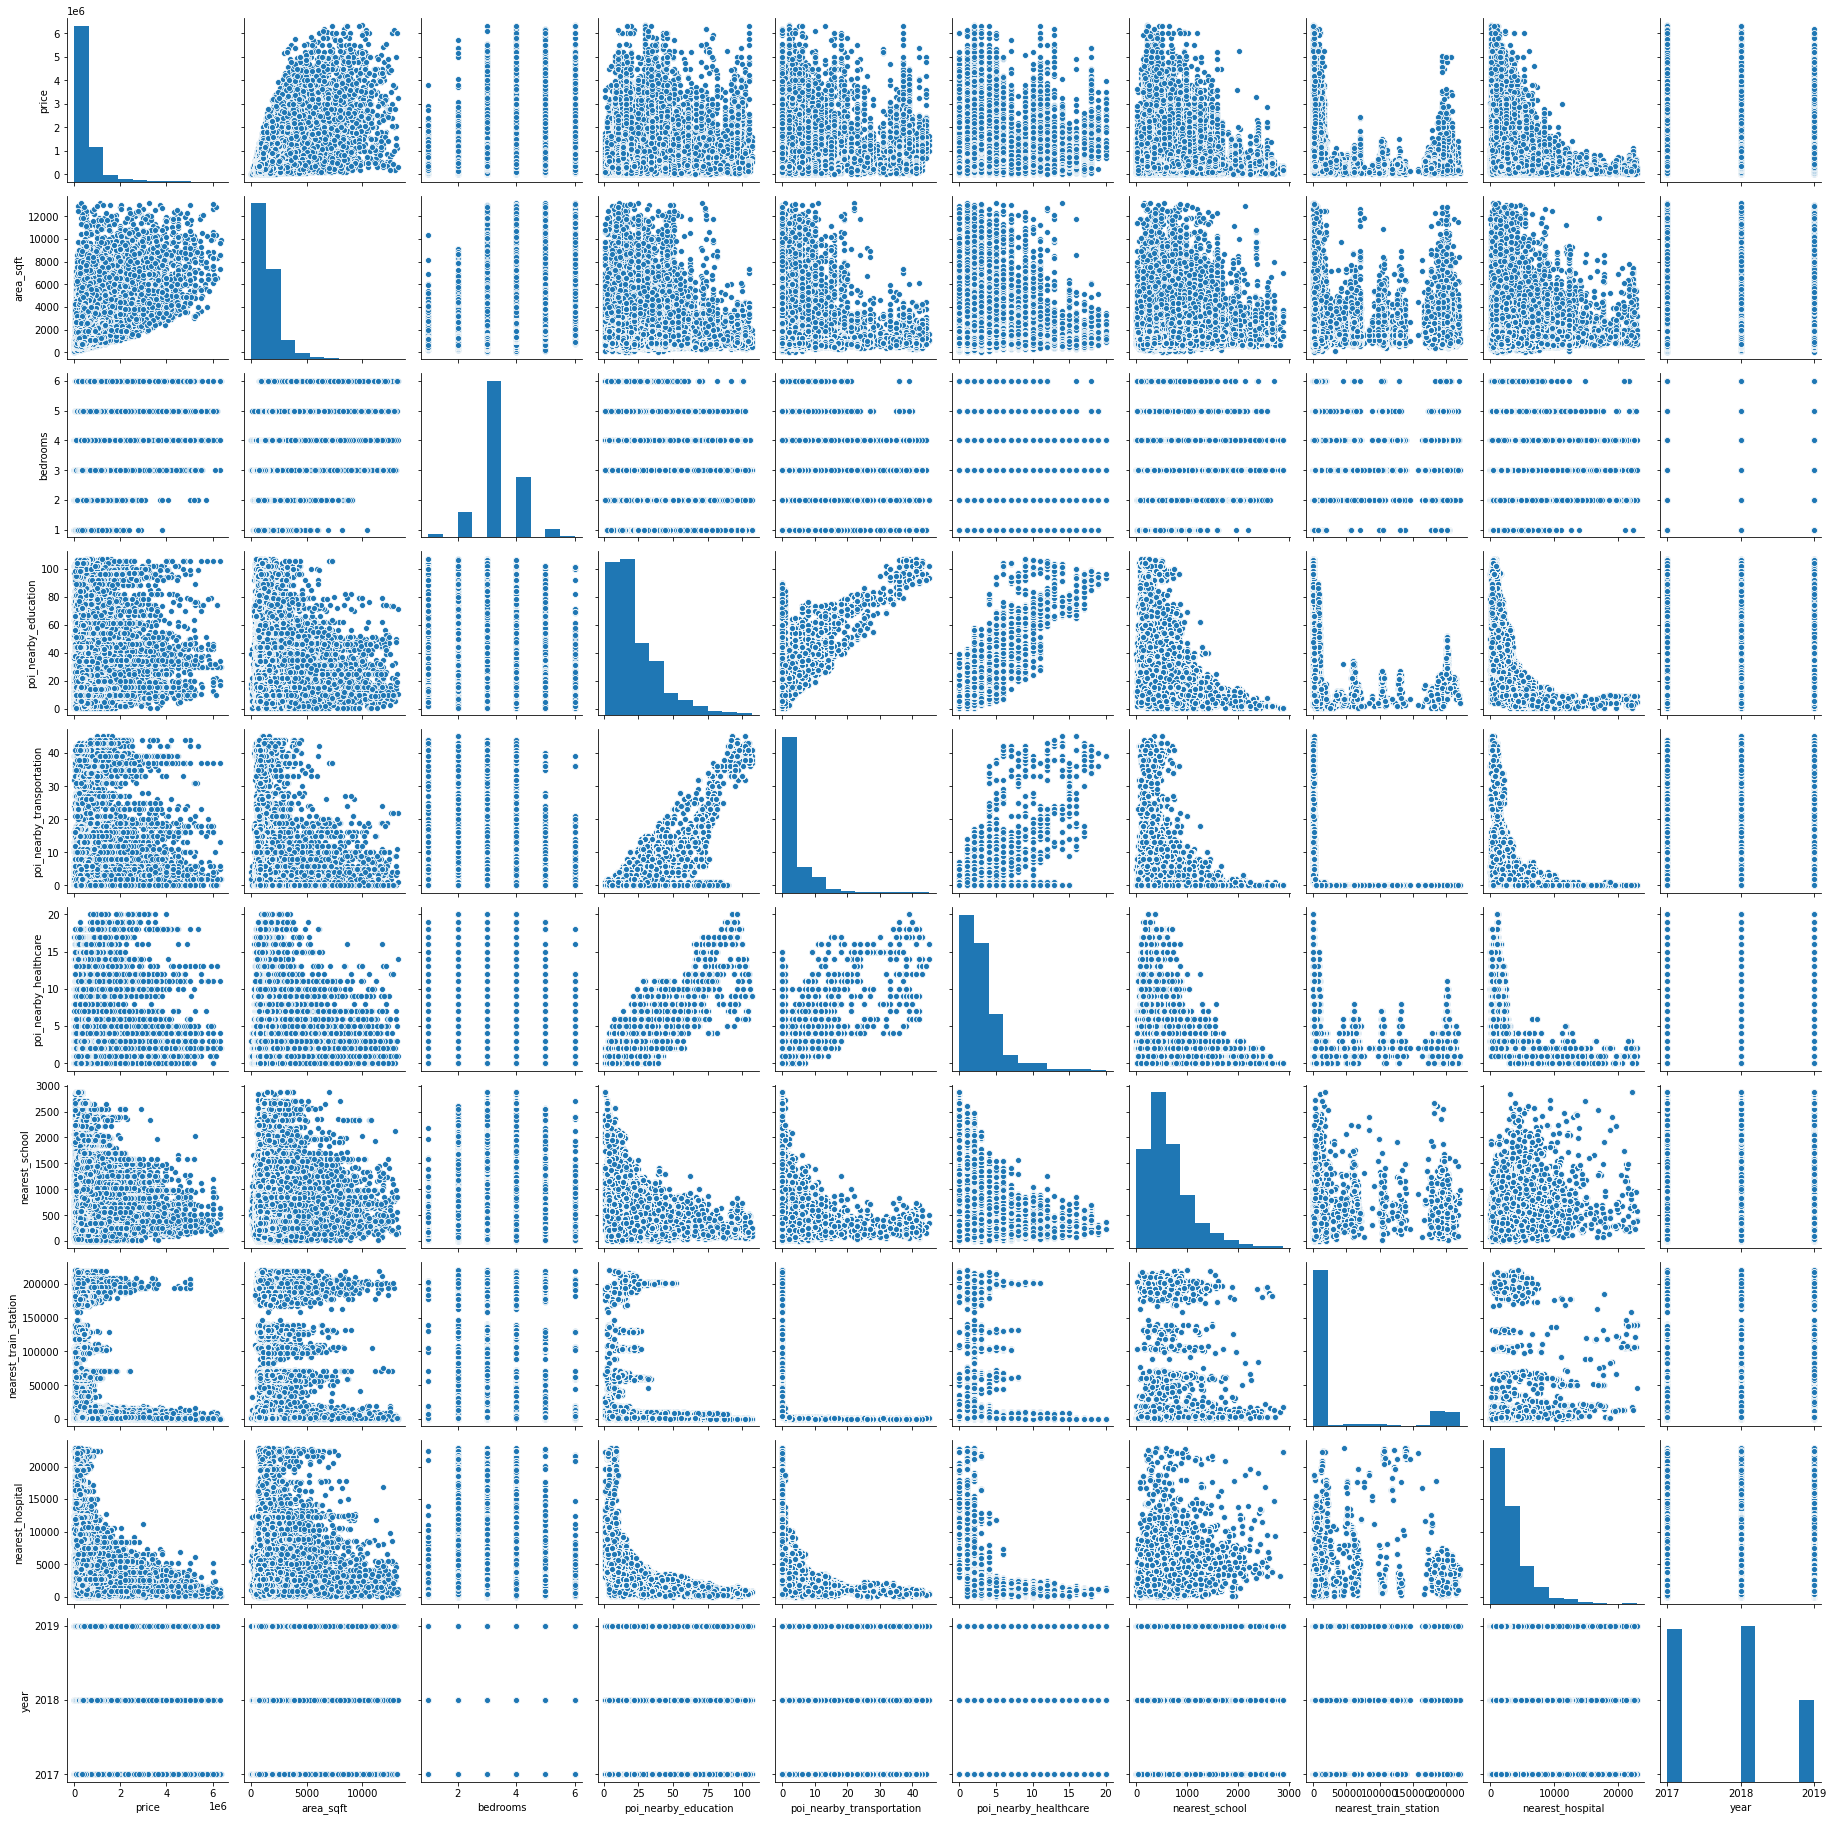

In [25]:
# sns.pairplot(transactions[['price', 'area_sqft', 'bedrooms', 'total_poi_nearby', 'nearest_poi']])
sns.pairplot(transactions[[
    'price', 'area_sqft', 'bedrooms', 'poi_nearby_education','poi_nearby_transportation','poi_nearby_healthcare', 
    'nearest_school', 'nearest_train_station', 'nearest_hospital', 'year'
]])

In [26]:
transactions.shape

(187429, 25)

In [27]:
transactions.to_csv(transaction_csv)